<a href="https://colab.research.google.com/github/mohamedfarhat-github/NLP-Project-exam-generator./blob/main/Mohamed_Farhat_Papa_Mademba_Gaye_NLP_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PROJECT : Natural Language Processing  (NLP)

## Question Generation : Exam generator 

Authors: Mohamed Farhat, Papa Mademba Gaye

If you have any question or if something is not clear please contact us by email.

## Goal:

- Recover and create a comprehensive dataset of contexts, questions and answers for reading comprehension purposes
- Create a model capable of generating, even partially, questions. 
- Use the aforementioned model to creat MCQ/fill in/ direct questions;

We make use of various sources for our codes. The sources are mentioned when their codes are used and we have also used Matthieu Labeau codes from his labs on NLP.

### Very important :
The NewsQA Dataset link that we provide here must not be shared with anyone. The distribution of this dataset is prohibited (mainly due to the CNN stories part of the dataset). Interested parties should generate their own datasets using the instructions found in the following link : [Link to NewsQA](https://github.com/Maluuba/newsqa)

P.S: If the reader is interested in generating their own datset then they might encounter a problem downloading the QA part from Microsoft database. A workaround this is to use a VPN.


<div class="alert alert-info">
    <h2>Part 0: Getting the necessary packages </h2>
</div>

In [ ]:
import os
import numpy as np
import math
import pandas as pd
import json
import re
from spacy.lang.en import English
from tqdm import tqdm
import torch
from torchtext.legacy import data, vocab
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils import clip_grad_norm_
import operator
from sklearn.neighbors import NearestNeighbors
import gdown 
import requests, zipfile, io
import matplotlib.pyplot as plt

In [ ]:
# if a package doesn't exist use the following command (replace package_name by the actual package name)
# !pip install package_name

<div class="alert alert-info">
    <h2> Part 1: Downloading, inspecting and merging the datasets </h2>
</div>

Let's begin by creating a directory for our data, we advise the reader to put this notebook in a folder if they haven't already.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = os.path.join(os.getcwd(), 'gdrive', 'My Drive')

Mounted at /content/gdrive


In [ ]:
# Let's create a data directory that will contain all the data for our project
if not os.path.exists(os.path.join(root_path, 'Data')): # if the directory isn't created yet
    os.mkdir(os.path.join(root_path ,'Data')) # create it
data_root = os.path.join(root_path, 'Data') # Our data path

<div class="alert alert-info">
    <h3> Part 1.1 : The Standford Question Answering Dataset V2.0 </h3>
</div>

Stanford Question Answering Dataset V2.0 (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable. SQuAD v2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones.  Generally, the dataset is used for question answering tasks but here we adapt it for question generation which happens to be the inverse task. 
 
We will now explore the dataset which is provided as 2 json files one for training and one for development. The structure of both is similar and we will explore the training one. The reader is free to explore the other one.

Let's download the 2 parts, but first let's create a directory for our dataset.

In [ ]:
if not os.path.exists(os.path.join(data_root, 'SQuADV2.0')): # check if the squad dir isn't created
    os.mkdir(os.path.join(data_root, 'SQuADV2.0')) # Create squad dir if so
squad_root = os.path.join(data_root, 'SQuADV2.0') # Path to squad dataset

In [ ]:
url = 'https://drive.google.com/uc?id=1iMxDRC2T5DpO8K3UFcW3UsirBION5-iF' #Link to datset training part
output = os.path.join(squad_root, 'train-v2.0.json')
gdown.download(url, output, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1iMxDRC2T5DpO8K3UFcW3UsirBION5-iF
To: /content/gdrive/My Drive/Data/SQuADV2.0/train-v2.0.json
42.1MB [00:01, 40.8MB/s]


'/content/gdrive/My Drive/Data/SQuADV2.0/train-v2.0.json'

In [ ]:
url = 'https://drive.google.com/uc?id=1wfMYYBrjQjDn3vpUcKGybwKxWxMldg6f' #Link to the dev part 
output = os.path.join(squad_root, 'dev-v2.0.json')
gdown.download(url, output, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1wfMYYBrjQjDn3vpUcKGybwKxWxMldg6f
To: /content/gdrive/My Drive/Data/SQuADV2.0/dev-v2.0.json
4.37MB [00:00, 20.7MB/s]


'/content/gdrive/My Drive/Data/SQuADV2.0/dev-v2.0.json'

In [ ]:
 # Loading both using pandas
train = pd.read_json(os.path.join(squad_root, 'train-v2.0.json'), orient='column')
dev = pd.read_json(os.path.join(squad_root, 'dev-v2.0.json'), orient='column')

Now we create a function to visualise the context, the question and the answer as well as the theme or the title of the subject  which can be a person, a place, ... Each answer is a part of the context in the case where an answer exists or a question is valid. These can be explored using the fields of the json file.

In [ ]:
def print_question_squad(data, idx_title, idx_paragraph, idx_question):
    
    title = data['data'][idx_title]['title']
    paragraph = data['data'][idx_title]['paragraphs'][idx_paragraph]['context']
    question = data['data'][idx_title]['paragraphs'][idx_paragraph]['qas'][idx_question]['question']
    answer = data['data'][idx_title]['paragraphs'][idx_paragraph]['qas'][idx_question]['answers'][0]['text']
    answer_start = data['data'][idx_title]['paragraphs'][idx_paragraph]['qas'][idx_question]['answers'][0]['answer_start']
    output =  f"\033[1mThe title is : \033[0m{title}\n\033[1mThe paragraph is : \033[0m\n{paragraph}\n" +\
    f"\033[1mThe question  is : \033[0m\n{question}\n\033[1mThe answer starts at index  \033[0m{answer_start}" +\
    f"\033[1m and the answer is : \033[0m{answer}"   
    
    print(output)

Let's print an example, feel free to try any other combination.

In [ ]:
idx_title, idx_question, idx_paragraph = 0, 0, 0
print_question_squad(train, idx_title, idx_paragraph, idx_question)

The title is : Beyoncé
The paragraph is : 
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
The question  is : 
When did Beyonce start becoming popular?
The answer starts at index  269 and the answer is : in the late 1990s


Lets see how many titles, paragraphs and questions our dataset includes 

In [ ]:
def data_stats_squad(data):
    
    titles_count = len(data['data'])
    tot_para_count = 0
    tot_quest_count = 0
    for idx_title in range(titles_count):
        para_count = len(data['data'][idx_title]['paragraphs'])
        tot_para_count += para_count

        for idx_paragraph in range(para_count):
            quest_count = len(data['data'][idx_title]['paragraphs'][idx_paragraph]['qas'])

            tot_quest_count += quest_count

    print(f'There are {titles_count} titles')
    print(f'There are {tot_para_count} paragraphs')
    print(f'There are {tot_quest_count} questions')

In [ ]:
data_stats_squad(train)

There are 442 titles
There are 19035 paragraphs
There are 130319 questions


<div class="alert alert-info">
    <h3> Part 1.2 : The NewsQA V1.0 dataset </h3>
</div>

The NewsQA was introduced by Trischler et al. in NewsQA: A Machine Comprehension Dataset. The NewsQA dataset is a crowd-sourced machine reading comprehension dataset of 120,000 question-answer pairs. 
Documents are CNN news articles.
- Questions are written by human users in natural language.
- Answers may be multiword passages of the source text.
- Questions may be unanswerable.
- NewsQA is collected using a 3-stage, siloed process.
- Questioners see only an article’s headline and highlights.
- Answerers see the question and the full article, then select an answer passage.
- Validators see the article, the question, and a set of answers that they rank.
- NewsQA is more natural and more challenging than previous datasets.

The dataset has two formats : a csv one and a json one. The structucre of both can be found in the official repository that was provided earlier.

Let's create a NewsQA directory, download both versions of the dataset and load the csv one. We will deal with the json one later.

In [ ]:
if not os.path.exists(os.path.join(data_root, 'NewsQA')): # Check if directory exists
    os.mkdir(os.path.join(data_root, 'NewsQA')) # create dir if no dir exists
newsqa_root = os.path.join(data_root, 'NewsQA') # dir path

In [ ]:
url = 'https://drive.google.com/uc?id=1UDrkV2NUzptknTH1OxNRAQptjLj3gPm7' # CSV file link
output = os.path.join(newsqa_root, 'combined-newsqa-data-v1.csv')
gdown.download(url, output, quiet=False) 

url = 'https://drive.google.com/uc?id=1-pKxlTolnWYzZCO6XpHWFGghdnqMwT6U' # json file link
output = os.path.join(newsqa_root, 'combined-newsqa-data-v1.json')
gdown.download(url, output, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1UDrkV2NUzptknTH1OxNRAQptjLj3gPm7
To: /content/gdrive/My Drive/Data/NewsQA/combined-newsqa-data-v1.csv
467MB [00:04, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-pKxlTolnWYzZCO6XpHWFGghdnqMwT6U
To: /content/gdrive/My Drive/Data/NewsQA/combined-newsqa-data-v1.json
84.1MB [00:01, 46.7MB/s]


'/content/gdrive/My Drive/Data/NewsQA/combined-newsqa-data-v1.json'

In [ ]:
newsqa = pd.read_csv(os.path.join(newsqa_root, 'combined-newsqa-data-v1.csv')) # Load the csv file using pandas

Let's compute some statistics on the dataset. The reader is free to explore more statistics but these are the ones that we're mainly interested in (stories, questions and answers)

In [ ]:
def data_stats_newsqa(data):
    
    # Total number of stories 
    print(f'There are {len(data.story_id.unique())} unique stories and {len(newsqa)} stories')
    # Number of absent answers
    print(f'The number of absent answers is {len(data[data.is_answer_absent == 1.0])}')
    # Number of bad questions
    print(f'The number of bad questions is',len(data[data.is_question_bad.str.contains('1.0')]))

In [ ]:
data_stats_newsqa(newsqa)

There are 12744 unique stories and 119633 stories
The number of absent answers is 6178
The number of bad questions is 6646


Let's print an example of  a story with its question and answer

In [ ]:
# lets print a story, its question and the answer or answers

def print_story_newsqa(data, story_ind=0):
    
    story = data.loc[story_ind].story_text
    
    if data.loc[story_ind].is_answer_absent != 1:
        
        if pd.isnull(data.loc[story_ind].validated_answers):
            
            answer_ranges = re.findall(r"[\w']+", data.loc[story_ind].answer_char_ranges)
            answer_ranges = list(filter(lambda x: x != 'None', answer_ranges))
            answers = [story[int(ind_prd):int(ind_nxt)]+"\t" for ind_prd, ind_nxt in zip(answer_ranges[::2], answer_ranges[1::2])]
        
        else : 
            
            answer_ranges = re.findall(r"[\w']+",  ','.join(list((json.loads(data.loc[story_ind].validated_answers).keys()))))
            answer_ranges = list(filter(lambda x: x != 'none', answer_ranges))
            answers = [story[int(ind_prd):int(ind_nxt)]+"\t" for ind_prd, ind_nxt in zip(answer_ranges[::2], answer_ranges[1::2])]
    else :
        
        answers = 'No valid answer'
        
    if data.loc[story_ind].is_question_bad == '1.0':
        
        question = 'Bad question'
    else : 
        
        question = data.loc[story_ind].question
    output =  f"\033[1mThe story is : \033[0m{story}\n\033[1mThe question is: \033[0m\n{question}\n" +\
    f"\033[1mThe answer/s is/are : \033[0m\n"   
    
    print(output)
    print(*answers)

In [ ]:
print_story_newsqa(newsqa, 2)

The story is : Johannesburg (CNN) -- Miffed by a visa delay that led the Dalai Lama to cancel a trip to South Africa, Archbishop Desmond Tutu lashed out at his government Tuesday, saying it had acted worse than apartheid regimes and had forgotten all that the nation stood for.





"When we used to apply for passports under the apartheid government, we never knew until the last moment what their decision was," Tutu said at a news conference. "Our government is worse than the apartheid government because at least you were expecting it from the apartheid government.





"I have to say that I can't believe this. I really can't believe this," Tutu said. "You have to wake me up and tell me this is actually happening here."





The Dalai Lama scrapped his planned trip to South Africa this week after the nation failed to issue him a visa in time, his spokesman said.





Visa applications for him and his entourage were submitted to the South African High Commission in New Delhi, India, at t

<div class="alert alert-info">
    <h3> Part 1.3 : Joining the datasets </h3>
</div>

Before joining the datasets, we will need to create a tokenizer for the context be it the paragraph, the answers or the questions. For this we will employ the spacy tokenizer. 

In [ ]:
tokenizer = English() # instantiate a tokenizer
# tokenizer.add_pipe('sentencizer'); # Create a pipeline, Note that this might not work depending on spacy's version
tokenizer.add_pipe(tokenizer.create_pipe('sentencizer')) # Use this if the above option doesn't work

def format_context(context):
    
    rep_dict = {"]": " ] ", "[": " [ ", "\n" : " ", "''": '" ', "``": '" '} # dictionary for substituting 
    re.sub('({})'.format('|'.join(map(re.escape, rep_dict.keys()))), lambda m: rep_dict[m.group()], context)
    return context

def words_token(context):
    # used to tokenize a sentence 
    tokens = [tok.text for tok in tokenizer(context) if tok.text]
    return [token for token in tokens if token.strip("\n").strip()] 

def sents_token(context):
    # used to tokenize  a paragraph/context
    return [[token.text for token in sentence if token.text] for sentence in tokenizer(context).sents]

def convert_idx(context, tks):
    # convert a token into an index
    crt, spans = 0, []
    for tok in tks:
        crt = context.find(tok, crt)
        if crt < 0:
            print("Can't find token {}".format(tok)) # raise exception if token isn't found
            raise Exception()
        spans.append((crt, crt + len(tok)))
        crt += len(tok)
    return spans

Now we will defrag our dataset into its different components : answers, contexts/paragraphs, sentences and questions then store each in a file

In [ ]:
def defrag_squad(data, label='train'):
    
    #Create a file for each fragment
    with open(os.path.join(squad_root, label + '.context'), 'w', encoding="utf-8") as context_file,\
        open(os.path.join(squad_root, label + '.sentences'), 'w', encoding="utf-8") as sentence_file,\
        open(os.path.join(squad_root, label + '.question'), 'w', encoding="utf-8") as question_file,\
        open(os.path.join(squad_root, label + '.answer'), 'w', encoding="utf-8") as answer_file:
        # let's loop over the titles 
        for idx_art in range(len(data)):
            # read each context/paragraph
            par_l = data['data'][idx_art]['paragraphs']
            # Loop over sentences/paragraphs in the context 
            for par in par_l:
                # process the context
                context = par['context']
                context = format_context(context)
                context_tks = words_token(context)
                con_sents = sents_token(context)
                spans = convert_idx(context, context_tks)
                tok_nbr= 0 
                # get the first token index in each sentence
                first_tok_sent = []
                for sent in con_sents:
                    first_tok_sent.append(tok_nbr)
                    tok_nbr += len(sent)
                # recover the questions 
                qa_l = par['qas']
                # Loop over the questions
                for qa in qa_l:
                    # read a question and process it
                    question = qa['question']
                    question = format_context(question)
                    q_tok = words_token(question)
                    # discard bad questions
                    if q_tok[-1] != '?':
                        continue
                    # check if an answers exists in the training data in case of traning 
                    if label == "train":
                        idx_ans = 1 if qa['answers'] else 0
                    # this for the dev part  
                    else:
                        idx_ans = len(qa['answers'])
                    # If the answer exists
                    if idx_ans:
                        # loop over the answer
                        for id_ans in range(idx_ans):
                            # preprocess and get the answer range/span
                            answer = qa['answers'][id_ans]['text']
                            answer = format_context(answer)
                            ans_tok = words_token(answer)
                            ans_strt = qa['answers'][id_ans]['answer_start']
                            ans_stp = ans_strt + len(answer)
                            ans_span = []
                            # get the index of the answer span
                            for idx, span in enumerate(spans):
                                if not (ans_stp <= span[0] or ans_strt >= span[1]):
                                    ans_span.append(idx) # fill in the answer span
                            if not ans_span:
                                continue
                            # get the answer from the spans
                            sent_tks = []
                            for idx, start in enumerate(first_tok_sent):
                                if ans_span[0] >= start:
                                    sent_tks = con_sents[idx]
                                    ans_sent_span = [span - start for span in ans_span]  
                                else:
                                    break
                            if not sent_tks:
                                print("Sentence cannot be found")
                                raise Exception()
                        # Write each component in its file, we mark the interesting portion using 1 marker
                        context_file.write(" ".join([token + u"￨" + "1" if idx in ans_span else token + u"￨" + "0" for idx, token in enumerate(context_tks)]) + "\n")
                        sentence_file.write(" ".join([token + u"￨" + "1" if idx in ans_sent_span else token + u"￨" + "0" for idx, token in enumerate(sent_tks)]) + "\n")
                        question_file.write(" ".join([token for token in q_tok]) + "\n")
                        answer_file.write(" ".join([token for token in ans_tok]) + "\n")


Let's defrag each part of the dataset : the train and the development one

In [ ]:
defrag_squad(train, label='train') 

In [ ]:
defrag_squad(dev, label='dev') 

We will also defrag the NewsQA dataset like the squad one. We will use the json file here. We repeat the same process as in the squad dataset

In [ ]:
def defrag_newsqa(data):
    #loop over label
    labels = ["train", "dev"]
    
    for label in labels:
        # create a file for each fragment : answers, contexts, questions and sentences
        with open(os.path.join(newsqa_root, label + ".context"), "w", encoding="utf-8") as context_file,\
             open(os.path.join(newsqa_root, label + ".sentences"), "w", encoding="utf-8") as sentence_file,\
             open(os.path.join(newsqa_root, label + ".question"), "w", encoding="utf-8") as question_file,\
             open(os.path.join(newsqa_root, label + ".answer"), "w", encoding="utf-8") as answer_file:
            # loop over articles 
            for article in data["data"]:
                # read the context and preprocess it
                # same procedure as the previous dataset
                context = article["text"]
                cont_tks = words_token(context)
                cont_sents = sents_token(context)
                spans = convert_idx(context, cont_tks)
                tks_nbr = 0
                first_tok_sent = []
                for sent in cont_sents:
                    first_tok_sent.append(tks_nbr)
                    tks_nbr += len(sent)
                # discard articles that are not in the category of interest 
                if not article["type"] == label:
                    continue
                # loop over questions   
                for question in article["questions"]:
                    # get only good question 
                    if question.get("isQuestionBad") == 0 and question["consensus"].get("s"):
                        
                        quest = question["q"].strip()
                        
                        if quest[-1] != "?" :
                            continue
                        # get the answer and its span
                        ans_strt = question["consensus"]["s"]
                        ans = context[question["consensus"]["s"]: question["consensus"]["e"]].strip(".| ").strip("\n")
                        ans_stp = ans_strt + len(ans)
                        ans_span = []
                        
                        for idx, span in enumerate(spans):
                            
                            if not (ans_stp <= span[0] or ans_strt >= span[1]):
                                ans_span.append(idx)
                                
                        if not ans_span:
                            continue

                        sent_tks = []
                        for idx, strt in enumerate(first_tok_sent):
                            
                            if ans_span[0] >= strt:
                                
                                sent_tks = cont_sents[idx]
                                ans_sent_span = [span - strt for span in ans_span]
                                
                            else:
                                break

                        sent = []
                        # get the sentence with the answer tags for tokens (1 for good, 0 for bad)
                        for idx, tok in enumerate(sent_tks):
                            
                            if tok.strip("\n").strip():
                                
                                if idx in ans_sent_span:
                                    sent.append(tok + u"￨" + "1")
                                    
                                else:
                                    sent.append(tok + u"￨" + "0")
                                    
                        # remove the CNN tag from stories to get clean context       
                        sent = " ".join(sent)
                        sent = sent.strip()
                        idx = sent.find("(￨0 CNN￨0 )￨0 --￨0 ")
                        
                        if idx > -1:
                            sent = sent[idx + len("(￨0 CNN￨0 )￨0 --￨0 "):]

                        ctxt = []
                        
                        for idx, tok in enumerate(cont_tks):
                            
                            if tok.strip("\n").strip():
                                
                                if idx in ans_span:
                                    ctxt.append(tok + u"￨" + "1")
                                    
                                else:
                                    ctxt.append(tok + u"￨" + "0")
                                    
                        ctxt = " ".join(ctxt)
                        ctxt = ctxt.strip()
                        idx = ctxt.find("(￨0 CNN￨0 )￨0 --￨0 ")
                        
                        if idx > -1:
                            ctxt = ctxt[idx + len("(￨0 CNN￨0 )￨0 --￨0 "):]
                            
                        # Writing content to respective files
                        context_file.write(ctxt + "\n")
                        sentence_file.write(sent + "\n")
                        question_file.write(quest + "\n")
                        answer_file.write(ans + "\n")

Here we read the json file and defrag the newsqa dataset.

In [ ]:
newsqa = pd.read_json(os.path.join(newsqa_root, 'combined-newsqa-data-v1.json'))

In [ ]:
defrag_newsqa(newsqa)

Having defragged the datsets, we now merge each component of each dataset with its respective counterpart

In [ ]:
def concat_files(squad_path, newsqa_path, to_dir, label="train"):
    # We will only consider the contexts as we want to create a reading comprehension question generator
    ext = ".context"
    sentence_files = [os.path.join(squad_path, label + ext),
                      os.path.join(newsqa_path, label + ext)]
    # getting question files
    question_files = [os.path.join(squad_path, label + ".question"),
                      os.path.join(newsqa_path, label + ".question")]
    # Create directory for final data
    if not os.path.exists(to_dir):
        os.makedirs(to_dir)
    # names for the final files
    out_sentence_filename = os.path.join(to_dir, label + ext)
    out_question_filename = os.path.join(to_dir, label + ".question")
    # concatenate files and writing them into respective directory 
    for infiles, outfile in zip([sentence_files, question_files], [out_sentence_filename, out_question_filename]):
        
        with open(outfile, "w", encoding='utf8') as o:
            for f in infiles:
                with open(f, encoding='utf8') as infile:
                    for line in infile:
                        o.write(line)

    with open(out_sentence_filename, "r", encoding='utf8') as f,\
         open(out_question_filename, "r", encoding='utf8') as g:
        sentence_lines = f.readlines()
        question_lines = g.readlines()

    sentence_lines, question_lines = zip(
        *[(s, q) for s, q in sorted(zip(sentence_lines, question_lines), key=lambda x: len(words_token(x[0])))])

    with open(out_sentence_filename, "w", encoding='utf8') as f,\
         open(out_question_filename, "w", encoding='utf8') as g:
        for line in sentence_lines:
            f.write(line)
        for line in question_lines:
            g.write(line)

In [ ]:
# create directory for the concatenated data
if not os.path.exists(os.path.join(data_root, 'Concatenated')):
    os.mkdir(os.path.join(data_root, 'Concatenated'))
to_dir = os.path.join(data_root, 'Concatenated')
# concatenate train and development files
concat_files(squad_root, newsqa_root, to_dir, label="train")
concat_files(squad_root, newsqa_root, to_dir, label="dev")

<div class="alert alert-info">
    <h2> Part 2 : Preprocessing data </h2>
</div>

<div class="alert alert-info">
    <h3> Part 2.1 : Downloading glove embedding </h3>
</div>

We will use GLoVe (wikipedia 2014 + gigaword 5) embedding. We will download the zip file and extract it in a folder as it is faster than loading with an API.


In [ ]:
if not os.path.exists(os.path.join(data_root, 'GLoVe')): # Create dir
    os.mkdir(os.path.join(data_root, 'GLoVe'))

In [ ]:
request = requests.get('http://nlp.stanford.edu/data/glove.6B.zip') # Download GLoVe embedding

In [ ]:
# extracting the data to the respective directory
zipped = zipfile.ZipFile(io.BytesIO(request.content)) 
zipped.extractall(os.path.join(data_root, 'GLoVe'))

In [ ]:
# parameters for the preprocessing
min_len_context = 5
min_len_sentence = 5
min_len_question = 5
max_len_context = 100
max_len_question = 20
word_embed_sz = 300
ans_embed_sz = 2
in_vocab_sz = 45000
out_vocab_sz = 28000

In [ ]:
# We adapt the following codes from 
# https://github.com/pytorch/text/blob/master/torchtext/datasets/translation.py
# to be able to control the max length of the source and target sentences
SOS_WORD = '<SOS>'
EOS_WORD = '<EOS>'
PAD_WORD = '<PAD>'

def read_data(text, sep=u"￨"):
    return [t.split(sep)[0] for t in text.split()], [t.split(sep)[1] for t in text.split()]

class MaxlenTranslationDataset(data.Dataset):

    def __init__(self, path, exts, fields, max_len=None, **kwargs):

        if not isinstance(fields[0], (tuple, list)):
            fields = [('src', fields[0]), ('trg', fields[1]), ('feat', fields[2])]

        src_path, trg_path = tuple(os.path.expanduser(path + x) for x in exts)

        examples = []
        with open(src_path, encoding='utf8') as src_file, open(trg_path, encoding='utf8') as trg_file:
            for src_line, trg_line in tqdm(zip(src_file, trg_file)):
                src_line, feat_line = read_data(src_line)
                trg_line = trg_line.split(' ')
                if max_len is not None:
                    src_line = src_line[:max_len]
                    src_line = str(' '.join(src_line))
                    trg_line = trg_line[:max_len]
                    trg_line = str(' '.join(trg_line))
                    feat_line = feat_line[:max_len]
                    feat_line = str(' '.join(feat_line))

                if src_line != '' and trg_line != '':
                    examples.append(data.Example.fromlist(
                        [src_line, trg_line, feat_line], fields))

        super(MaxlenTranslationDataset, self).__init__(examples, fields, **kwargs)

class DataPreprocessor(object):
    
    def __init__(self):
        self.src_field, self.trg_field, self.src_feat_field = self.generate_fields()

    def preprocess(self, train_path, val_path, train_file, val_file, glove_path, src_lang, trg_lang, max_len=None):
        
        print("Preprocessing train dataset...")
        
        train_dataset = self.generate_data(train_path, src_lang, trg_lang, max_len)

        print("Saving train dataset...")
        
        self.save_data(train_file, train_dataset)

        print("Preprocessing validation dataset...")
        
        val_dataset = self.generate_data(val_path, src_lang, trg_lang, max_len)

        print("Saving validation dataset...")
        
        self.save_data(val_file, val_dataset)
        self.src_field.build_vocab(train_dataset, max_size=in_vocab_sz)
        self.trg_field.build_vocab(train_dataset, max_size=out_vocab_sz)
        self.src_feat_field.build_vocab(train_dataset, max_size=out_vocab_sz)
        src_vocab, trg_vocab, src_feat_vocab = self.generate_vocabs()
        vocabs = {'src_vocab': src_vocab, 'trg_vocab': trg_vocab, 'src_feat_vocab':src_feat_vocab}

        return train_dataset, val_dataset, vocabs

    def load_data(self, train_file, val_file, glove_path):
        
        train_dataset = torch.load(train_file)
        train_examples = train_dataset['examples']

        val_dataset = torch.load(val_file)
        val_examples = val_dataset['examples']

        fields = [('src', self.src_field), ('trg', self.trg_field), ('feat', self.src_feat_field)]
        train_dataset = data.Dataset(fields=fields, examples=train_examples)
        val_dataset = data.Dataset(fields=fields, examples=val_examples)
        vec = vocab.Vectors(os.path.join(glove_path, "glove.6B.{}d.txt".format(word_embed_sz)))
        self.src_field.build_vocab(train_dataset, vectors=vec, max_size=in_vocab_sz)
        self.trg_field.build_vocab(train_dataset, vectors=vec, max_size=out_vocab_sz)
        self.src_feat_field.build_vocab(train_dataset, vectors=vec, max_size=out_vocab_sz)
        src_vocab, trg_vocab, src_feat_vocab = self.generate_vocabs()
        vocabs = {'src_vocab': src_vocab, 'trg_vocab': trg_vocab, 'src_feat_vocab': src_feat_vocab}

        return train_dataset, val_dataset, vocabs

    def save_data(self, data_file, dataset):
        
        examples = vars(dataset)['examples']
        dataset = {'examples': examples}
        torch.save(dataset, data_file)

    def generate_fields(self):
        
        src_field = data.Field(tokenize=words_token,
                               init_token=SOS_WORD,
                               eos_token=EOS_WORD,
                               pad_token=PAD_WORD,
                               include_lengths=True,
                               batch_first=True,
                               fix_length=max_len_context)

        trg_field = data.Field(tokenize=words_token,
                               init_token=SOS_WORD,
                               eos_token=EOS_WORD,
                               pad_token=PAD_WORD,
                               include_lengths=True,
                               batch_first=True,
                               fix_length=max_len_question)

        src_feat_field = data.Field(tokenize=words_token,
                                    pad_token=PAD_WORD,
                                    include_lengths=False,
                                    batch_first=True,
                                    fix_length=max_len_context)

        return src_field, trg_field, src_feat_field

    def generate_data(self, data_path, src_lang, trg_lang, max_len=None):
        
        exts = ('.' + src_lang, '.' + trg_lang)

        dataset = MaxlenTranslationDataset(path=data_path,
                                           exts=(exts),
                                           fields=(self.src_field, self.trg_field, self.src_feat_field),
                                           max_len=max_len)

        return dataset

    def generate_vocabs(self):
        
        src_vocab = self.src_field.vocab
        trg_vocab = self.trg_field.vocab
        src_feat_vocab = self.src_feat_field.vocab

        return src_vocab, trg_vocab, src_feat_vocab

In [ ]:
# instantiate the preprocessor class, preprocess data and saving into pt format
preprocessor = DataPreprocessor()
ext = "context"
preprocessor.preprocess(os.path.join(to_dir, "train"),
              os.path.join(to_dir, "dev"),
              os.path.join(to_dir, "train-dataset.pt"),
              os.path.join(to_dir, "dev-dataset.pt"),
              os.path.join(data_root, 'GLoVe'),
              ext, "question", max_len=max_len_context);

161it [00:00, 1609.64it/s]

Preprocessing train dataset...


143126it [01:50, 1294.21it/s]


Saving train dataset...


269it [00:00, 2686.92it/s]

Preprocessing validation dataset...


9091it [00:07, 1237.72it/s]


Saving validation dataset...


<div class="alert alert-info">
    <h2> Part 3 : Neural question generation through seq2seq model </h2>
</div>

We adapt the following model from Learning to Ask: Neural Question Generation for Reading Comprehension by Xinya Du et al.

<div class="alert alert-info">
    <h3> Part 3.1 : Coding the layers </h3>
</div>

In [ ]:
# The below functions are taken from
# https://github.com/huggingface/transfer-learning-conv-ai/blob/master/train.py 
def top_filtering(logits, top_k=0, top_p=0.0, threshold=-float('Inf'), filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k, top-p (nucleus) and/or threshold filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k: <=0: no filtering, >0: keep only top k tokens with highest probability.
            top_p: <=0.0: no filtering, >0.0: keep only a subset S of candidates, where S is the smallest subset
                whose total probability mass is greater than or equal to the threshold top_p.
                In practice, we select the highest probability tokens whose cumulative probability mass exceeds
                the threshold top_p.
            threshold: a minimal threshold to keep logits
    """
    assert logits.dim() == 1  # Only work for batch size 1 for now - could update but it would obfuscate a bit the code
    top_k = min(top_k, logits.size(-1))
    if top_k > 0:
        # Remove all tokens with a probability less than the last token in the top-k tokens
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        # Compute cumulative probabilities of sorted tokens
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probabilities = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probabilities > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # Back to unsorted indices and set them to -infinity
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value

    indices_to_remove = logits < threshold
    logits[indices_to_remove] = filter_value

    return logits


def sample_sequence(logits, top_k, top_p, tempt, greedy=False):
    
    logits = logits[0] / tempt
    logits = top_filtering(logits, top_k=top_k, top_p=top_p)
    probs = F.softmax(logits, dim=-1)
    pred = torch.topk(probs, 1)[1] if greedy else torch.multinomial(probs, 1)
    
    return pred, probs

Parameters for decoding  and learning

In [ ]:
top_k = 0.
top_p = 0.9
tempt = 0.7
dcd_type = "top_k"

Layers for the model

In [ ]:
# Embedding layer
class Embedding(nn.Module):
    def __init__(self, w_vctrs, pad_idx, drop_prob):
        super(Embedding, self).__init__()
        self.drop_prob = drop_prob
        self.word_embed = nn.Embedding.from_pretrained(w_vctrs, padding_idx=pad_idx, freeze=False)
        self.ans_embed = nn.Embedding(4, ans_embed_sz, padding_idx=pad_idx)

    def forward(self, x, y=None):
        embed = self.word_embed(x)
        if y != None:
            ans_embed = self.ans_embed(y)
            embed = torch.cat((embed, ans_embed), dim=-1)
        embed = F.dropout(embed, self.drop_prob, self.training)
        return embed

#Encoder layer

class Encoder(nn.Module):
    
    def __init__(self, in_sz, hid_sz, nbr_lyr, w_vctrs, device, bidrct=True, drop_prob=0.):
        super(Encoder, self).__init__()
        nbr_drct= 2 if bidrct else 1
        hid_sz //= nbr_drct

        self.embed = Embedding(w_vctrs, pad_idx=1, drop_prob=drop_prob)
        self.drop_prob = drop_prob
        self.rnn = nn.LSTM(in_sz, hid_sz, nbr_lyr,
                           batch_first=True,
                           bidirectional=bidrct,
                           dropout=drop_prob if nbr_lyr > 1 else 0)
        self.device=device
        
    def forward(self, x, lens, y=None):

        x = self.embed(x, y)
        x = pack_padded_sequence(x, lens.cpu(), batch_first=True).to(self.device)
        x, (hidden, cell) = self.rnn(x) 
        x, _ = pad_packed_sequence(x, batch_first=True)
        return x, (hidden, cell)

# Decoder layer 

class Decoder(nn.Module):
    def __init__(self, in_sz, hid_sz, w_vctrs, nbr_lyr, trg_vocab, device, dropout, attn=None,
                 min_len_sentence=min_len_sentence, max_len_sentence=max_len_question, top_k=top_k, top_p=top_p,
                 tempt=tempt, dcd_type=dcd_type):
        
        super().__init__()
        self.out_dim = len(trg_vocab.itos)
        self.embed = nn.Embedding.from_pretrained(w_vctrs, freeze=True)
        self.rnn = nn.LSTM(in_sz, hid_sz, nbr_lyr, batch_first=True, bidirectional=False, dropout=dropout)
        self.attn = Attention(hid_sz=hid_sz, attn_type="general") if attn else None
        self.generate = Generator(dcd_sz=hid_sz, out_dim=len(trg_vocab.itos))
        self.dropout = nn.Dropout(dropout)
        self.min_len_sentence = min_len_sentence
        self.max_len_sentence = max_len_sentence
        self.top_k = top_k
        self.top_p = top_p
        self.tempt = tempt
        self.dcd_type = dcd_type
        self.spctks_idx = [trg_vocab.stoi[t] for t in ["<EOS>", "<PAD>"]]
        self.device=device

    def rnn_decode(self, dcd_in, dcd_hid, enc_out):
        
        dcd_out, dcd_hid = self.rnn(dcd_in, dcd_hid)

        if self.attn:
            dcd_out, _ = self.attn(dcd_out, enc_out)

        return self.dropout(dcd_out), dcd_hid

    def top_k_top_p_decode(self, dcd_hid, enc_out):
        
        batch_sz = enc_out.size(0)
        out_l = []

        dcd_in = torch.zeros(enc_out.size(0), 1).fill_(2).long().to(self.device)
        in_feed = torch.zeros(batch_sz, 1, enc_out.size(2), device=self.device)

        for i in range(0, self.max_len_sentence):
            
            dcd_in = torch.cat((self.embed(dcd_in), in_feed), 2)
            dcd_out, dcd_hid = self.rnn_decode(dcd_in, dcd_hid, enc_out)
            out = self.generate(dcd_out).to(device)
            out, probs = sample_sequence(out, self.top_k, self.top_p, self.tempt, False)
        
            if i < self.min_len_sentence and out.item() in self.spctks_idx:
                while out.item() in self.spctks_idx:
                    out = torch.multinomial(probs, num_samples=1).to(self.device)
                    
            if out.item() in self.spctks_idx:
                return out_l
            
            out_l.append(out.item())
            dcd_in = out.long().unsqueeze(1)
            in_feed = dcd_out

        return out_l

    def greedy_decode(self, dcd_hid, enc_out):
        
        batch_sz = enc_out.size(0)
        out_l = []
        dcd_in = torch.zeros(enc_out.size(0), 1).fill_(2).long().to(device)
        in_feed = torch.zeros(batch_sz, 1, enc_out.size(2), device=self.device)

        for t in range(0, self.max_len_sentence):
            
            dcd_in = self.embed(dcd_in) 
            dcd_in = torch.cat((dcd_in, in_feed), 2)
            dcd_out, dcd_hid = self.rnn_decode(dcd_in, dcd_hid, enc_out)
            output = self.generate(dcd_out)
            _, res = output.data.topk(1)
            res = res.view(-1)

            if res.item() in self.spctks_idx:
                return out_l

            out_l.append(res.item())
            dcd_in = res.detach().view(-1, 1)
            in_feed = dcd_out

        return out_l

    def forward(self, enc_out, enc_hid, quest=None):
        
        batch_sz = enc_out.size(0)
        out_l = []
        enc_hid = tuple(
                (torch.cat((lyr[0:lyr.size(0):2], lyr[1:lyr.size(0):2]), dim=2) for lyr in enc_hid))
        dcd_hid, enc_out = enc_hid, enc_out[:, -1, :].unsqueeze(1) if not self.attn else enc_out

        if quest is not None: 
            
            quest_emb = self.embed(quest)
            in_feed = torch.zeros(batch_sz, 1, enc_out.size(2), device=self.device)
            
            for dcd_in in quest_emb[:, :-1, :].split(1, 1):
                
                dcd_in = torch.cat((dcd_in, in_feed), 2)
                dcd_out, dcd_hid = self.rnn_decode(dcd_in, dcd_hid, enc_out)
                out_l.append(self.generate(dcd_out))
                in_feed = dcd_out

        else: 
            
            if self.dcd_type not in ["top_k", "greedy"]:
              
                print("Decode can be greedy or top_k")
                return out_l
            
            if self.dcd_type == "top_k":
                out_l = self.top_k_top_p_decode(dcd_hid, enc_out)
                
            else:
                out_l = self.greedy_decode(dcd_hid, enc_out)

        return out_l

# Generator layer
class Generator(nn.Module):
    def __init__(self, dcd_sz, out_dim):
        
        super(Generator, self).__init__()
        self.generate = nn.LogSoftmax(dim=-1)
        self.generator = nn.Linear(dcd_sz, out_dim)

    def forward(self, x):
        
        return  self.generate(self.generator(x)).squeeze(1)

# Attention layer

class Attention(nn.Module):
    
    def __init__(self, hid_sz, attn_type="dot"):
        
        super(Attention, self).__init__()
        assert attn_type in ["dot", "general", "mlp"], (
            "Attention type is not valid : {:s}).".format(attn_type))
        self.hid_sz = hid_sz
        self.attn_type = attn_type

        if self.attn_type == "general":
            
            self.input_lin = nn.Linear(hid_sz, hid_sz, bias=False)
            
        elif self.attn_type == "mlp":
            
            self.linear_cont = nn.Linear(hid_sz, hid_sz, bias=False)
            self.linear_query = nn.Linear(hid_sz, hid_sz, bias=True)
            self.to_val = nn.Linear(hid_sz, 1, bias=False)
        
        self.output_lin = nn.Linear(hid_sz * 2, hid_sz, bias= self.attn_type == "mlp")

    # compute score
    def scoring(self, hid_tar, hid_src):
        
        src_batch, src_len, src_dim = hid_src.size()
        tar_batch, tar_len, tar_dim = hid_tar.size()
        
        if self.attn_type in ["general", "dot"]:
            
            if self.attn_type == "general":
                
                hid_tar = self.input_lin(hid_tar.view(tar_batch * tar_len, tar_dim)).view(tar_batch, tar_len, tar_dim)
            
            return torch.bmm(hid_tar, hid_src.transpose(1, 2))

        else:
            
            hid_sz = self.hid_sz
            word_query = self.linear_query(hid_tar.view(-1, hid_sz))
            word_query = word_query.view(tar_batch, tar_len, 1, hid_sz)
            word_query = word_query.expand(tar_batch, tar_len, src_len, hid_sz)
            unit_hid = self.linear_cont(hid_src.contiguous().view(-1, hid_sz))
            unit_hid = unit_hid.view(src_batch, 1, src_len, hid_sz)
            unit_hid = unit_hid.expand(src_batch, tgt_len, src_len, hidden_size)
            
            return self.to_val(torch.tanh(word_query + unit_hid).view(-1, hid_sz)).view(tar_batch, tar_len, src_len)

    def forward(self, dcd_out, enc_out, enc_out_lens=None):
        
        batch, src_len, src_sz = enc_out.size()
        _ , tar_len, _ = dcd_out.size()
        alignment = self.scoring(dcd_out, enc_out)
        alignment = F.softmax(alignment.view(batch * tar_len, src_len), -1)
        alignment = alignment.view(batch, tar_len, src_len)
        cont_vec = torch.bmm(alignment, enc_out)
        concat_cont_vec = torch.cat((cont_vec, dcd_out), 2).view(batch * tar_len, hid_sz * 2)
        hid_attn = self.output_lin(concat_cont_vec).view(batch, tar_len, hid_sz)
        
        if self.attn_type in ["general", "dot"]:
            
            hid_attn = torch.tanh(hid_attn)
        hid_attn = hid_attn.transpose(0, 1).contiguous()
        alignment = alignment.transpose(0, 1).contiguous()

        return hid_attn.permute(1, 0, 2), alignment

<div class="alert alert-info">
    <h3> Part 3.2 : Create the seq2seq model </h3>
</div>

In [ ]:
class Seq2Seq(nn.Module):
    
    def __init__(self, in_vocab, hid_sz, nbr_lyr, trg_vocab, device, drop_prob=0., use_answer=True):
        
        super(Seq2Seq, self).__init__()
        
        self.enc = Encoder(in_sz=in_vocab.vectors.size(1) if not use_answer else in_vocab.vectors.size(1) +
                                  ans_embed_sz,
                                  hid_sz=hid_sz,
                                  nbr_lyr=nbr_lyr,
                                  w_vctrs=in_vocab.vectors,
                                  device = device,
                                  bidrct=True,
                                  drop_prob=drop_prob if nbr_lyr > 1 else 0.)

        self.dec = Decoder(in_sz=in_vocab.vectors.size(1) + hid_sz,
                                  hid_sz=hid_sz,
                                  w_vctrs=in_vocab.vectors,
                                  trg_vocab=trg_vocab,
                                  device = device,
                                  nbr_lyr=nbr_lyr,
                                  dropout=drop_prob if nbr_lyr > 1 else 0.,
                                  attn=True)
        
    def forward(self, sent, len_sent, quest=None, ans=None):
      
        enc_out, enc_hid = self.enc(sent, len_sent, ans)
        output = self.dec(enc_out, enc_hid, quest)

        return output

We create the following functions to evaluate our model

In [ ]:

def reshape_pred(pred):

    return  torch.stack(pred).squeeze(0).transpose(0, 1).contiguous()


def crt_pred(pred, grd_trth, padding_idx):
    # Compute the correct number of prediction
    pred = pred.view(-1, pred.size(2))
    pred = pred.max(1)[1]
    grd_trth = grd_trth[:, 1:].contiguous()
    nn_pad = grd_trth.view(-1).ne(padding_idx)
    nbr_crt = pred.eq(grd_trth.view(-1)).masked_select(nn_pad).sum().item()
    nbr_nn_pad = nn_pad.sum().item()
    
    return nbr_nn_pad, nbr_crt

def compute_loss(loss, nbr_smpl):
    # compute the loss
    return np.round(loss / nbr_smpl, 2)

def compute_accuracy(nbr_crt, nbr_smpl):
    # compute accuracy
    return np.round(100 * (nbr_crt / nbr_smpl), 2)

def perplex(loss, nbr_smpl):
    # compute perplexity
    return np.exp(loss / nbr_smpl)

<div class="alert alert-info">
    <h3> Part 3.3 : Training the model </h3>
</div>

Setting learning parameters and training ones too. 

In [ ]:
nbr_epochs = 15
batch_sz = 64
lr = 1.0
hid_sz = 600
nbr_lyr = 2
drop_prob = 0.3
start_decay_epoch = 8
decay_rate = 0.5
use_answer = True


train_loss_l = []
train_accuracy_l = []
train_perplexity_l = []
valid_loss_l = []
valid_accuracy_l = []
valid_perplexity_l = []


#Load data
preprocessor = DataPreprocessor()
train_dataset, valid_dataset, vocabs = preprocessor.load_data(os.path.join(to_dir, "train-dataset.pt"),
                                                    os.path.join(to_dir, "dev-dataset.pt"),
                                                    os.path.join(data_root, 'GLoVe'))
# Use gpu if available otherwise the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# use dataloaders to feed data to the model
train_dataloader = data.BucketIterator(train_dataset,
                                       batch_size=batch_sz,
                                       sort_key=lambda x: len(x.src),
                                       sort_within_batch=True,
                                       device=device,
                                       shuffle=False)


valid_dataloader = data.BucketIterator(valid_dataset,
                                       batch_size=batch_sz,
                                       sort_key=lambda x: len(x.src),
                                       sort_within_batch=True,
                                       device=device,
                                       shuffle=True)

print("Length of training data loader is:", len(train_dataloader))
print("Length of valid data loader is:", len(valid_dataloader))

100%|███████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:48<00:00, 8236.56it/s]


Length of training data loader is: 2237
Length of valid data loader is: 143


In [ ]:
# instantiate the seq2seq model and load on device
model = Seq2Seq(in_vocab=vocabs["src_vocab"],
                hid_sz=hid_sz,
                nbr_lyr=nbr_lyr,
                trg_vocab=vocabs["trg_vocab"],
                drop_prob=drop_prob,
                device=device,
                use_answer=use_answer)
model = model.to(device)

In [ ]:
padding_idx = vocabs['trg_vocab'].stoi["<PAD>"]
criterion = nn.NLLLoss(ignore_index=padding_idx, reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=list(range(start_decay_epoch,nbr_epochs + 1)),
                                                 gamma=decay_rate)

print('Model started training')

for epoch in range(nbr_epochs):
    
    model.train()
    loss_ep, nbr_smpl_ep, nbr_crt_ep = 0, 0, 0
    
    for i, batch in enumerate(train_dataloader):
        sent, len_sent, quest = batch.src[0].to(device), batch.src[1].to(device), batch.trg[0].to(device)
        ans = batch.feat.to(device) if use_answer else None
        optimizer.zero_grad()
        pred = model(sent, len_sent, quest, ans)
        pred = reshape_pred(pred)
        loss = criterion(pred.view(-1, pred.size(2)), quest[:, 1:].contiguous().view(-1))
        nbr_nn_pad, nbr_crt = crt_pred(pred, quest, padding_idx)
        loss_ep += loss
        nbr_crt_ep += nbr_crt
        nbr_smpl_ep += nbr_nn_pad
        loss.backward()
        clip_grad_norm_(model.parameters(), 5.)
        optimizer.step()
    scheduler.step()
    loss_ep = loss_ep.cpu().detach().numpy()
    loss_ep = compute_loss(loss_ep, nbr_smpl_ep)
    accuracy = compute_accuracy(nbr_crt_ep, nbr_smpl_ep)
    perplexity = perplex(loss_ep, nbr_smpl_ep)
    train_loss_l.append(loss_ep)
    train_accuracy_l.append(accuracy)
    train_perplexity_l.append(perplexity)
    print('Training in epoch {}, loss : {}, accuracy : {}, perplexity :  {}'.format(epoch, loss, accuracy, perplexity))

    model.eval()
    with torch.no_grad():
        loss_ep_val, nbr_smpl_ep_val, nbr_crt_ep_val = 0, 0, 0
        for i, batch in enumerate(valid_dataloader):
            sent, len_sent, quest = batch.src[0].to(device), batch.src[1].to(device), batch.trg[0].to(device)
            ans = batch.feat.to(device) if use_answer else None
            pred = model(sent, len_sent, quest,  ans)
            pred = reshape_pred(pred)
            loss = criterion(pred.view(-1, pred.size(2)), quest[:, 1:].contiguous().view(-1))
            nbr_nn_pad, nbr_crt = crt_pred(pred, quest, padding_idx)
            loss_ep_val += loss
            nbr_crt_ep_val += nbr_crt
            nbr_smpl_ep_val += nbr_nn_pad
        loss_ep_val = loss_ep_val.cpu().detach().numpy()
        loss_ep_val = compute_loss(loss_ep_val, nbr_smpl_ep_val)
        accuracy = compute_accuracy(nbr_crt_ep_val, nbr_smpl_ep_val)
        perplexity = perplex(loss_ep_val, nbr_smpl_ep_val) 
        valid_loss_l.append(loss_ep_val)
        valid_accuracy_l.append(accuracy)
        valid_perplexity_l.append(perplexity)
        print('Validation in epoch {}, loss : {}, accuracy : {}, perplexity :  {}'.format(epoch, loss_ep_val, accuracy, perplexity))

Model started training
Training in epoch 0, loss : 1075.849853515625, accuracy : 26.53, perplexity :  1.0000035088027988
Validation in epoch 0, loss : 4.9, accuracy : 30.33, perplexity :  1.0000480912910015
Training in epoch 1, loss : 980.7755126953125, accuracy : 32.74, perplexity :  1.0000029389416527
Validation in epoch 1, loss : 4.55, accuracy : 32.86, perplexity :  1.0000446561220893
Training in epoch 2, loss : 944.5949096679688, accuracy : 35.18, perplexity :  1.000002708436113
Validation in epoch 2, loss : 4.35, accuracy : 33.7, perplexity :  1.0000426931737232
Training in epoch 3, loss : 894.9235229492188, accuracy : 37.17, perplexity :  1.0000025227511333
Validation in epoch 3, loss : 4.16, accuracy : 35.31, perplexity :  1.000040828376344
Training in epoch 4, loss : 838.9612426757812, accuracy : 38.96, perplexity :  1.0000023690808315
Validation in epoch 4, loss : 4.04, accuracy : 36.28, perplexity :  1.00003965061137
Training in epoch 5, loss : 810.04150390625, accuracy : 40

Let's print some plots

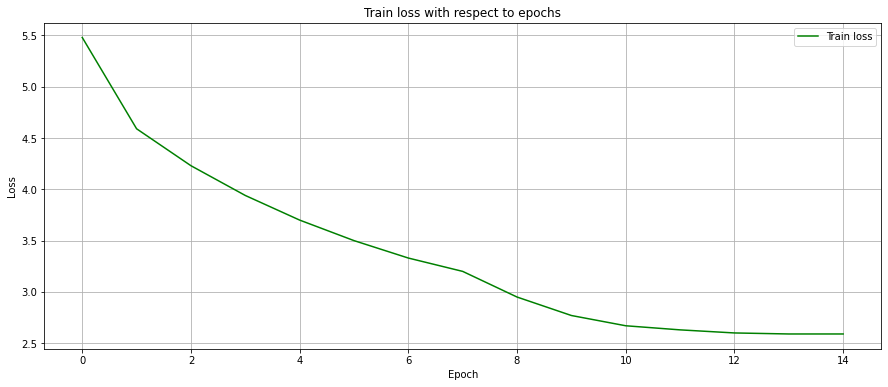

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(nbr_epochs), train_loss_l, '-g', label='Train loss')  # solid green
plt.grid()
plt.legend(loc="upper right")
plt.title('Train loss with respect to epochs');
plt.xlabel('Epoch')
plt.ylabel('Loss');

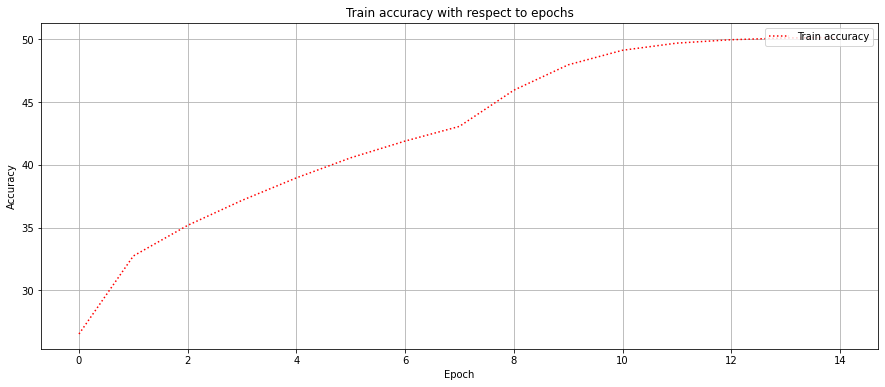

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(nbr_epochs), train_accuracy_l, ':r', label='Train accuracy') 
plt.grid()
plt.legend(loc="upper right")
plt.title('Train accuracy with respect to epochs');
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

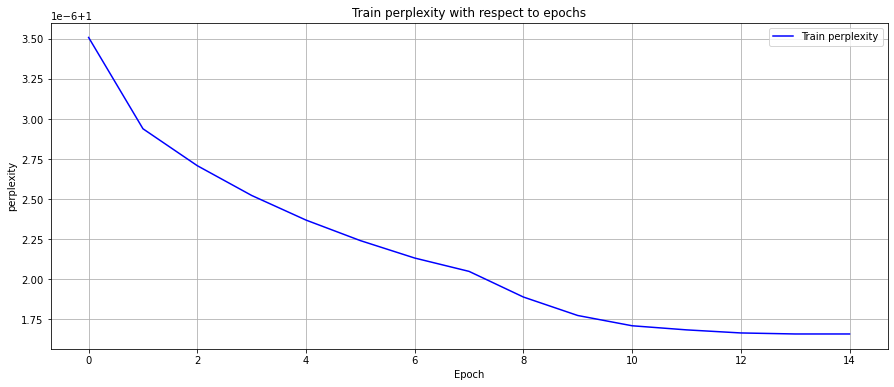

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(nbr_epochs), train_perplexity_l, '-b', label='Train perplexity') 
plt.grid()
plt.legend(loc="upper right")
plt.title('Train perplexity with respect to epochs');
plt.xlabel('Epoch')
plt.ylabel('perplexity');

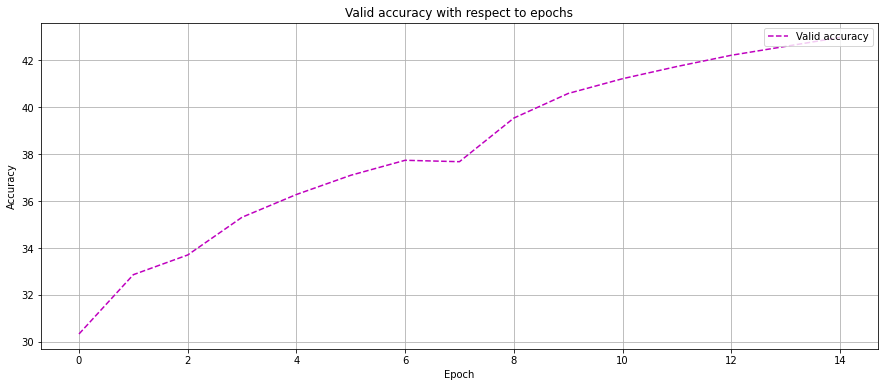

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(nbr_epochs), valid_accuracy_l, '--m', label='Valid accuracy') 
plt.grid()
plt.legend(loc="upper right")
plt.title('Valid accuracy with respect to epochs');
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

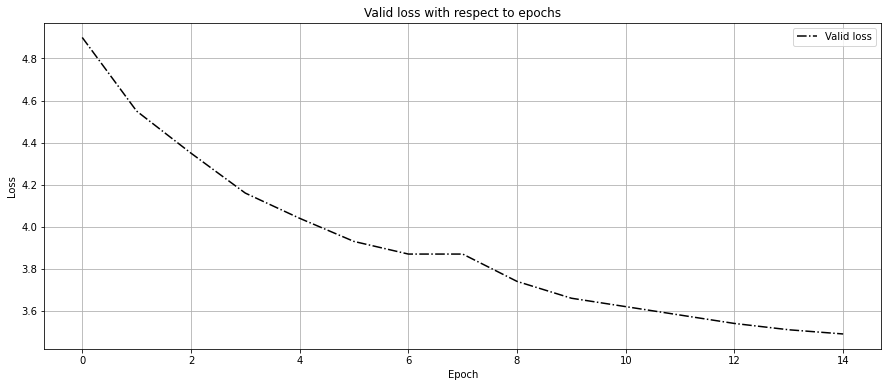

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(nbr_epochs), valid_loss_l, '-.k', label='Valid loss') 
plt.grid()
plt.legend(loc="upper right")
plt.title('Valid loss with respect to epochs');
plt.xlabel('Epoch')
plt.ylabel('Loss');

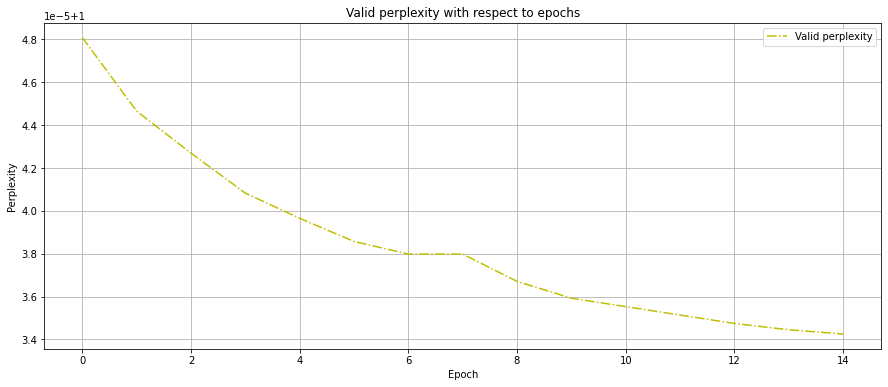

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(nbr_epochs), valid_perplexity_l, '-.y', label='Valid perplexity') 
plt.grid()
plt.legend(loc="upper right")
plt.title('Valid perplexity with respect to epochs');
plt.xlabel('Epoch')
plt.ylabel('Perplexity');

We can see that our model is able to learn and it is improving but in our experiments the accuracy (with all other metrics) caps at nearly 52 percent and learning won't improve for epochs above 15 which might prove that the model isn't able to understand the questions structure above a certain level.

Now let's generate some questions and see how it goes 

In [ ]:
batch_size_val = 1
ext = "context"
test_dataset = preprocessor.generate_data(os.path.join(to_dir, "dev"), ext,
                                "question", max_len=max_len_context)

test_dataloader = data.BucketIterator(test_dataset,
                                      batch_size=batch_size_val,
                                      sort_key=lambda x: len(x.sentence),
                                      shuffle=False)

9091it [00:09, 909.29it/s] 


In [ ]:
model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        sent, len_sen = batch.src[0].to(device), batch.src[1].to(device)
        ans = batch.feat.to(device) if use_answer else None
        pred = model(sent, len_sent, None, ans)
        pred = [vocabs["trg_vocab"].itos[i] for i in pred if vocabs["trg_vocab"].itos[i]]
        print(" ".join(pred[1:]))
        if i >19:
            break

have broad defined that not fit into the discussion ?
do some definitions that not have varying into time into into ?
do some aspect classes have ?
is a growing sport in southern California ?
does the trophy rank in southern California ?
sport does Brazil hold ?
city is popular for its tourist destinations ?
tourist destinations for its popular for its popular ?
rain and tourists restaurants are popular tourist destinations for its popular tourist attraction and what region
is <unk> popular popular popular for ?
district district of California <unk> ?
with <unk> Mountain , who is San Bernardino ?
neighborhoods is in San <unk> ?
can be defined by what ?
a time by can be defined by what by ?
can be defined by <unk> the time ?
sport is popular in southern California ?
<unk> <unk> does a Study <unk> compete in ?
is the name of the MBA <unk> in the <unk> Conference ?
what spring are the LGBT <unk> and <unk> <unk> field field ?
what division is the <unk> <unk> field field ?


From the results above, it is apparent that the model can to some extent generate a question albeit with lots of mistakes and sometimes require an interpretation to be understood. The most apparent mistake is the absence of the  ? mark at the end. Some questions don't have the WH word when it should be, instead they have a reversed form which prompts us to say that the model can't differenciate between WH questions and reversed form ones. The model clearly needs further tweaks for it to be able to generate coherent questions.

Let's try to generate an MCQ style question by using a KNN classifier and try to generate the nearest answers to the true one.

In [ ]:
def mcq(ans, vocab, sent, knn, alt=4):
    cont = [vocab['src_vocab'].itos[i] for i in sent[0]]
    mask =  [vocab["src_feat_vocab"].itos[i] for i in  ans[0]]
    idx = [vocab['src_vocab'].stoi[cont[i]] for i in range(len(cont)) if mask[i]=='1']
    nghbrs = [[] for _ in range(alt)]
    for id in idx:
        nghbr = knn.kneighbors(vocab['src_vocab'].vectors[id].reshape(1, -1), return_distance=False)[0]
        for i in range(alt):
            nghbrs[i].append(nghbr[i])
    worded = [[vocab['src_vocab'].itos[i] for i in sgt] for sgt in nghbrs]
    shuffle(worded)
    for i in range(alt):
        print(f'{i+1})')
        print(*worded[i], sep = " ")

In [ ]:
n_alt = 4
knn = NearestNeighbors(n_neighbors=n_alt)
knn.fit(vocabs['src_vocab'].vectors);

In [ ]:
model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        sent, len_sen = batch.src[0].to(device), batch.src[1].to(device)
        ans = batch.feat.to(device) if use_answer else None
        pred = model(sent, len_sent, None, ans)
        pred = [vocabs["trg_vocab"].itos[i] for i in pred if vocabs["trg_vocab"].itos[i]]
        print("Question : ")
        print(" ".join(pred[1:]))
        mcq(ans, vocabs, sent, knn, n_alt)
        print('\n')
        if i > 4:
            break

Question : 
have differences adherence that not fit into the understanding of a simple educational ?
1)
and few richness
2)
, some complexity
3)
. many sophistication
4)
but those subtlety


Question : 
dimensions colleges have varying binary into what ?
1)
it
2)
that
3)
same
4)
this


Question : 
type of ways have some degrees that not fit into the discussion parallel ?
1)
difficult
2)
problematic
3)
involve
4)
complicated


Question : 
sport is in southern California ?
1)
Magna
2)
Stafford
3)
Literature
4)
Stein


Question : 
what level level is the secondary school wrestling in southern sports ?
1)
same higher
2)
which low
3)
of well
4)
the high


Question : 
is a growing sport for high school football basketball ?
1)
an official school
2)
this according students
3)
another officials schools
4)
which saying elementary




We can see that this fails horribly as the questions are either bad or the answers aren't meaningful. Generating a question is different from the task of generating a question with multiple questions as the answers in the latter must be similar. We can conclude that this method is obselete. One might opt for a multi task model where the model learns the question and the answer thus it can generate the question and the answers without being divided into two parts.

<div class="alert alert-info">
    <h3> Part 4 : Fine-tuned BERT for question answering </h3>
</div>

We will see here how a fine tuned model can help us generate better answers than the ones we generated.

<div class="alert alert-info">
    <h3> Part 4.1 : Importing model and Tokenizer </h3>
</div>

In [ ]:
#!pip install git+https://github.com/huggingface/transformers

In [ ]:
#We start here by importing the pretrained bert model
# It was trained on version 1 of SQuAD
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
# We also need to import the tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
# A quick look at the structure of the model.
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12,

<div class="alert alert-info">
    <h3> Part 4.2 : Importing datasets </h3>
</div>

In [ ]:
#here we use the datasets created before and put them in lists for a better handling 
data_train = [],[] 
for i in range(len(train_dataset)):
    data_train[0].append(str(train_dataset.examples[i].src))
    data_train[1].append(str(train_dataset.examples[i].trg))
    
data_valid = [],[]
for i in range(len(valid_dataset)):
    data_valid[0].append(str(valid_dataset.examples[i].src))
    data_valid[1].append(str(valid_dataset.examples[i].trg))

In [ ]:
# Function to clean the text so that the pre-trained bert can work more efficiently
def cleaner(tokens):
    tokens = tokens.replace("[","")
    tokens2 = tokens.replace("]","")
    tokens3 = tokens2.replace("'", "")
    tokens4 = tokens3.replace(' "s"',"'s")
    tokens5 = tokens4.replace(",","")
    return tokens5

In [ ]:
#  clean datasets
clean_train = [], []
for i in range(len(data_train[0])):
    clean_train[0].append(cleaner(data_train[0][i]))
    clean_train[1].append(cleaner(data_train[1][i]))
    
    
    
clean_valid = [], []
for i in range(len(data_valid[0])):
    clean_valid[0].append(cleaner(data_valid[0][i]))
    clean_valid[1].append(cleaner(data_valid[1][i]))

<div class="alert alert-info">
    <h3> Part 4.3 : Applying the model on our datasests </h3>
</div>

In [ ]:
#this function is taken from:
# https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-

def answer_question(question, answer_text):
    #Tokenizeing the input
    
    input_ids = tokenizer.encode(question, answer_text)
    
    # ======== Set Segment IDs ========
    # Search the input_ids
    sep_index = input_ids.index(tokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a
    
    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    #run the model through the examples
    outputs = model(torch.tensor([input_ids]),
                    token_type_ids=torch.tensor([segment_ids]), 
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    answer = tokens[answer_start]
    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        else:
            answer += ' ' + tokens[i]
    print('Question: "' + question + '"')
    print('Answer: "' + answer + '"'"\n")

In [ ]:
# Code to apply the function on the whole train dataset
for i in range(len(clean_train[0])): 
    answer_question(clean_train[1][i], clean_train[0][i])

In [ ]:
# Snippet just to see that it works.
for i in range(12): 
    answer_question(clean_train[1][i], clean_train[0][i])

Question: "What state do Jason Chaffetz represent ?"
Answer: "utah"

Question: "What political party is Jared Polis in ?"
Answer: "d"

Question: "Who is Json Chaffetz ?"
Answer: "congressman jason chaffetz ( r"

Question: "What political party is Jared Polis associated with ?"
Answer: "d"

Question: "What area does Jason Chaffetz represent ?"
Answer: "utah : district 03"

Question: "What is Chaffetz "" party affiliation ?"
Answer: "r"

Question: "Who is the republican ?"
Answer: "jason chaffetz"

Question: "What is the name of the Republican ?"
Answer: "jason chaffetz"

Question: "A preaspirated consonant is marked how ?"
Answer: "by placing the aspiration modifier letter before the consonant symbol"

Question: "What represents a preaspirated bilabial stop ?"
Answer: "⟨ ʰp ⟩"

Question: "Which brains are easier to work on  vertebrates or invertebrates ?"
Answer: "invertebrate"

Question: "In 2011  what sort of Wikipedia addition did the National Archives make ?"
Answer: "wikiproject"



In [ ]:
for i in range(len(clean_valid[0])): 
    answer_question(clean_valid[1][i], clean_valid[0][i])

In [ ]:
for i in range(12): 
    answer_question(clean_valid[1][i], clean_valid[0][i])

Question: "What has complicated definitions that prevent classification into a framework ?"
Answer: "complexity classes"

Question: "Complexity classes are generally classified into what ?"
Answer: "what ? [SEP] of course some complexity classes have complicated definitions"

Question: "Difficulty in establishing a framework for complexity classes can be caused by what variable ?"
Answer: "complicated definitions"

Question: "What is a growing sport in southern California ?"
Answer: "rugby"

Question: "At which level of education is this sport becoming more popular ?"
Answer: "high school"

Question: "What is rugby rapidly becoming with high schools ?"
Answer: "official school sport"

Question: "What is the name of the desert city ?"
Answer: "palm springs"

Question: "Other than the desert city why do many locals and tourists frequent southern California ?"
Answer: "for its popular beaches"

Question: "Which region of California is Palm Springs located in ?"
Answer: "southern"

Questio

We can see that this model is better at generating answers than our 'medieval' one which we can exploit for the MCQ type questions

<div class="alert alert-info">
    <h2> Part 5 : Conclusion </h2>
</div>

Throughout this project we have managed to create a model to generate questions to a certain degree for exam generation. There is no doubt that the model needs more work for propre question generation. However, it is still far from a usable tool even for getting insights on potential questions. As for the MCQ questions and the fill in ones, we suspect that a model that generates questions and answers at the same time would be more adequate. This is a valid area of research and ideally our model would have generated something like the tool we find here [pretrained transformers for question generation](https://github.com/amontgomerie/question_generator).